<a href="https://colab.research.google.com/github/govindgnair23/Graph-Machine-Learning/blob/master/Intro_to_Graph_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

In this notebook, we will cover four different algorithms belonging to two major categories.

1.   Matrix Factorization Approaches
  *   Page Rank
  *   Deep Walk

2.   Graph Neural Networks
  * Graph SAGE
  * Graph Attention Networks (GAT)



# Page Rank

Page rank is a metric for measuring node importance in a graph.



*   It assigns greater importance to nodes that are connected to more important nodes.
*   It measures the probability that a random surfer arrives at a given node in the limit.



Consider the following sample graph:

In [ ]:
import networkx as nx

In [ ]:
G1 = nx.MultiDiGraph()
G1.add_nodes_from([1,2,3])
G1.add_edges_from([(1,1),(1,2),(2,1),(2,3),(3,2)])

[0, 0, 0, 0, 0]

In [ ]:
G1.number_of_nodes(),G1.number_of_edges()

(3, 5)

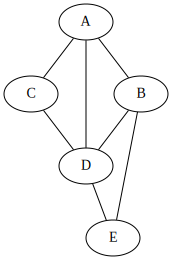

In [ ]:
from networkx.drawing import nx_pydot
from graphviz import Source

nx_pydot.write_dot(G1, 'multig.dot')
Source.from_file('multig.dot')

Rank $r_j$ for node $j$ is given by
$$r_j  = \underset{i \to j}{\sum}\frac{r_i}{d_i} $$

where $d_i$ is the out-degree of node $i$

E.g. $d_2 =2 $

A series of **flow equations** can thus be derived for the entire graph.

$$r_1 = \frac{r_1}{2} + \frac{r_2}{2} $$

$$r_2 = \frac{r_1}{2} + r_3 $$

$$r_3 = \frac{r_2}{2} $$


Re-arranging this gives

$$ \frac{r_1}{2} - \frac{r_2}{2} = 0 $$
$$ -\frac{r_1}{2} + r_2 - r_3 = 0 $$
$$-\frac{r_2}{2} +r_3 = 0 $$

This can be solved for small graphs by solving the system of linear equations if we add a constraint that the rank values sum up to 1 ( $r_1 +r_2+r+3 =1$ )to the third equation.



In [ ]:
import numpy as np

a = np.array([[0.5,-0.5, 0],
             [-0.5, 1 ,-1],
             [1, 0.5 ,2]])

b = np.array([0 , 0 , 1 ])

np.linalg.solve(a,b)


array([0.4, 0.4, 0.2])

### Matrix Formulation

The previous set of flow equations can be written as

$$\begin{bmatrix}
r_1\\
r_2\\
r_3
\end{bmatrix} =  \begin{bmatrix}
1/2 & 1/2 & 0\\
1/2 & 0 & 1\\
0 & 1/2 & 0
\end{bmatrix} \cdot \begin{bmatrix}
r_1\\
r_2\\
r_3
\end{bmatrix} $$

$$\textbf{r} = \textbf{M}\cdot \textbf{r} $$

Remember that for a matrix $\textbf{A}$ , if $\textbf{A}\vec{v} = \lambda \vec{v}$

Then $\lambda$ is the eigen value and $\vec{v}$ is the eigen vector.

$$\textbf{M}\cdot \textbf{r} = 1 \textbf{r} $$



$\textbf{M}$ is a *column stochastic adjaceny matrix* where column $i$ gives the probability of a random walker  at node $i$ reaching other nodes corresponing to the index of the elements in that column.

This means the page rank $\textbf{r}$ is an eigen vector of the matrix $\textbf{M}$ with eigen value of 1. This can be solved efficiently using the power iteration method.

Given a graph with N nodes

*   Initialize : $\textbf{r}^0 = [ 1/N,\dots,1/N]^T$
*   Iterate: $\textbf{r}^{t+1} = \textbf{M} \cdot \textbf{r}^t $ 
*   Stop when $|\textbf{r}^{t+1} - \textbf{r}^{t}| \lt \epsilon $



In [ ]:
def my_page_rank(G,num_iters=100,tol=1e-6):
  #Convert to column stochastic matrix
  W = nx.adjacency_matrix(nx.stochastic_graph(G)).todense().T
  N = G.number_of_nodes()
  r = np.ones(N)*(1/N)

  for _ in range(num_iters):
    r_old = r
    r = np.matmul(W,r)
    r = np.squeeze(np.asarray(r))
    error = np.linalg.norm(r - r_old,ord=1)
    if error < tol:
      break
  return r

In [ ]:
my_page_rank(G1)

array([0.40000008, 0.39999979, 0.20000013])

In [ ]:
nx.pagerank(G1)

{1: 0.3817175683766465, 2: 0.3987949981601664, 3: 0.21948743346318683}

### Problems with Above Formulation

#### 1) Dead Ends 

This causes importance to leak out.

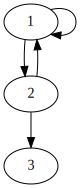

In [ ]:
G2 = nx.MultiDiGraph()
G2.add_nodes_from([1,2,3])
G2.add_edges_from([(1,1),(1,2),(2,1),(2,3)])

from networkx.drawing import nx_pydot
from graphviz import Source

nx_pydot.write_dot(G2, 'multig.dot')
Source.from_file('multig.dot')

In [ ]:
my_page_rank(G2)

array([1.79024475e-06, 1.10643211e-06, 6.83812648e-07])

In [ ]:
M2 = nx.adjacency_matrix(nx.stochastic_graph(G2)).todense().T
M2

matrix([[0.5, 0.5, 0. ],
        [0.5, 0. , 0. ],
        [0. , 0.5, 0. ]])

$\textbf{M}$ for this graph is column stochastic.

#### 2) Spider Traps

One node absorbs all the importance

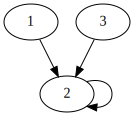

In [ ]:
G3 = nx.MultiDiGraph()
G3.add_nodes_from([1,2,3])
G3.add_edges_from([(1,2),(2,2),(3,2)])

nx_pydot.write_dot(G3, 'multig.dot')
Source.from_file('multig.dot')



In [ ]:
my_page_rank(G3)

array([0., 1., 0.])

In [ ]:
nx.adjacency_matrix(nx.stochastic_graph(G3)).todense().T

matrix([[0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.]])

## Solution

1) For Dead ends, make matrix $\textbf{M}$ colum stochastic so that the surfer gets teleported out to a different node if it lands in a dead end

In [ ]:
M2

matrix([[0.5, 0.5, 0. ],
        [0.5, 0. , 0. ],
        [0. , 0.5, 0. ]])

Adjust M2 by replacing the column of zeros.

In [ ]:
M2[:,2] = 1/3
M2

matrix([[0.5       , 0.5       , 0.33333333],
        [0.5       , 0.        , 0.33333333],
        [0.        , 0.5       , 0.33333333]])

2) For Spider traps, the surfer should get teleported out of the spider trap in a finite number of steps.

###  Random Teleports

* With probability $\alpha$ , follow a link at random
* With probability $1 - \alpha $ , jump to a random node

### Page Rank Equation

$$ r_j  = \underset{i \rightarrow j}{\sum} \alpha \frac{r_i}{d_i} + (1-\alpha)\frac{1}{N} $$

Probability of landing in node j is the probability of arriving at the node from some neighboring node + probability of  teleporting there directly.

In [ ]:
help(nx.pagerank)


Help on function pagerank in module networkx.algorithms.link_analysis.pagerank_alg:

pagerank(G, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)
    Returns the PageRank of the nodes in the graph.
    
    PageRank computes a ranking of the nodes in the graph G based on
    the structure of the incoming links. It was originally designed as
    an algorithm to rank web pages.
    
    Parameters
    ----------
    G : graph
      A NetworkX graph.  Undirected graphs will be converted to a directed
      graph with two directed edges for each undirected edge.
    
    alpha : float, optional
      Damping parameter for PageRank, default=0.85.
    
    personalization: dict, optional
      The "personalization vector" consisting of a dictionary with a
      key some subset of graph nodes and personalization value each of those.
      At least one personalization value must be non-zero.
      If not specfiied, a nodes personalization 

You can see we get the same value calculated above if we set $\alpha = 1$. However in the `pagerank` function,by default  $\alpha = 0.85$ 

In [ ]:
nx.pagerank(G1,alpha = 1)

{1: 0.39999976638170925, 2: 0.4000006116206255, 3: 0.1999996219976652}

Setting $\alpha = 0 $ means the surfer is randomly teleporting to nodes in the graph , so all nodes will have equal importance.

In [ ]:
nx.pagerank(G1,alpha = 0)

{1: 0.3333333333333333, 2: 0.3333333333333333, 3: 0.3333333333333333}

The `pagerank` function also addresses the dead end problem and the 🕷 trap problem

In [ ]:
nx.pagerank(G2)

{1: 0.4392217997696814, 2: 0.3082255419261199, 3: 0.2525526583041984}

In [ ]:
nx.pagerank(G3)

{1: 0.05, 2: 0.9, 3: 0.05}

# Deep Walk and Node2Vec

[Deepwalk](https://arxiv.org/abs/1403.6652) is a specific type of random walk node embedding algorithm proposed in 2014. It is a specific version of the more general [Node2vec](https://arxiv.org/abs/1607.00653) algorithm which is itself inspired by Skipgram word2vec model. A skipgram model attempts to predict the context or neighbors of a word given a word.

The goal of a node embedding is to learn a vector representation for each node such that similarity in the embeddings space approximates similarity in the graph.

There are two key components required to learn node embeddings.

1) Encoder that maps each node to a d-dimensional vector <br>
2) Similarity function that specifies a measure or score of similarity in the original graph <br>
3) A decoder the maps from the embeddings to the similarity score

## Encoder

Encoder for Deep Walk is an embedding  where each column represents the embedding of a node.

$$ENC(u) = z_u$$
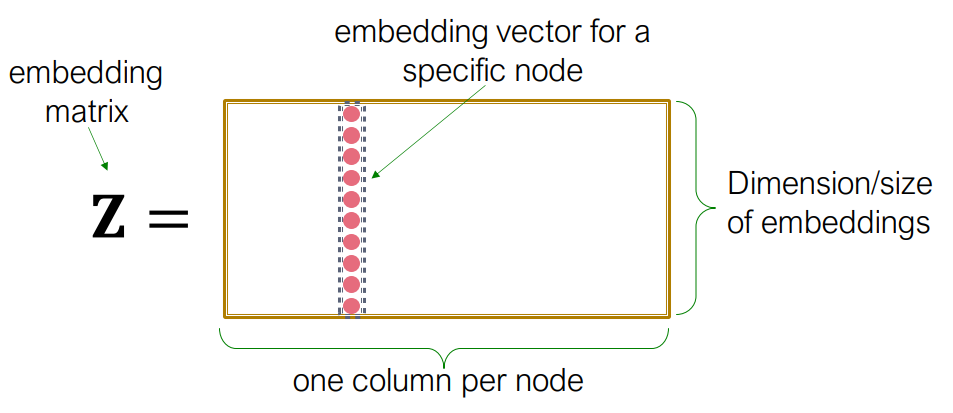



## Similarity Measure

The simplest similarity measure is the adjacency matrix $\textbf{A}$. Two nodes are similar only if they are connected.

For Deep Walk, two nodes $u$ & $v$ are similar if there is a high probability that you will reach $v$ from $u$ on an unbiased fixed length random walk.

Let $P_R(v|u)$ be the probability of visting node $v$ on random walks starting from node $u$ 

## Decoder

Typically a dot product between two embedding vectors is used.

$$DEC(u,v) = \textbf{z}_v^T\textbf{z}_u$$

## Objective



Learn vectors $z_v$ and $z_u$ for nodes $u$ and $v$ such that

$$\textbf{z}_v^T\textbf{z}_u  \propto similarity(u,v) $$

If we consider the adjacency matrix as a measure of similarity, then learning these embeddings simplifies to the following matrix factorization.

$$\textbf{A} = \textbf{Z}^T \textbf{Z} $$

However, this is a very narrow definition of similarity. A more useful defintion of similarity is the random walk similarity discussed earlier.

$$\textbf{z}_v^T\textbf{z}_u ∝ P_R(v|u)$$

These vectors can be learnt by maximizing the following objective function

$$\underset{f}{max} \prod\limits_{u \in V} P(N_r(u)|z_u)$$

$$\underset{f}{max} \sum\limits_{u \in V} log P(N_r(u)|z_u)$$

We want to learn $\textbf{z}_u$ for every node in the graph such that the probability of visiting the immediate random walk neighborhood of $v$ is maximized. This neighborhood $N_R(u)$ can be identified by doing an actual random walk for node $u$.


$$\mathcal{L} = \sum\limits_{u \in V}\sum\limits_{v \in N_R(u)}  log(P(v|z_u))$$

$P(v|z_u) $ can be parameterized as 
$$P(v|z_u) = \frac{exp(z_u^Tz_v)}{\sum_{n \in V} exp(z_u^Tz_n)} \dots (1)$$

Note that the denominator in the expression above requires us to look at every pair of nodes. This can be simplified by drawing samples.

Deep Walk (and Node2Vec) are considered a matrix factorization approach as it can be considered to be the factorization of a transformed adjacency matrix. See [here](https://youtu.be/r12qJZZVtqc?list=PLoROMvodv4rPLKxIpqhjhPgdQy7imNkDn&t=393) 

Note: The only difference between DeepWalk and node2vec is the way random walks are carried out. Deepwalk uses an unbiased random walk while node2vec uses a biased randomwalk.

##  A Simple Node Embedding Model

Here we will use the simplest notion of similarity. Nodes that are connected by an edge are similar whereas any two nodes that are not coonected are dissimilar.

In [ ]:
import networkx as nx
import torch

In [ ]:
G = nx.karate_club_graph()
nodes_attributes =  nx.get_node_attributes(G,'club') #Get club each node belongs to 

In [ ]:
node_clubs =list(nodes_attributes.values())
map = {'Mr. Hi':"red","Officer":"green"}
node_colors = [map[node] for node in node_clubs]

This network consists of two different communities as shown below.

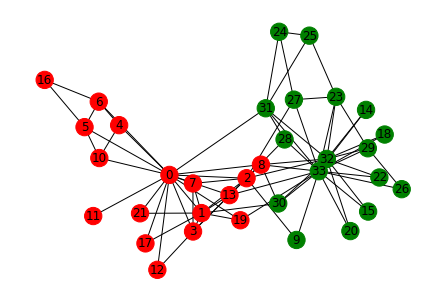

In [ ]:
nx.draw(G,with_labels = True,node_color = node_colors)

In [ ]:
#Number of edges and nodes
G.number_of_edges(),G.number_of_nodes()

(78, 34)

In [ ]:
#Get list of edges
pos_edge_list = list(G.edges())
# Convert list of positive edges into a tensor of right dimension
pos_edge_index = torch.tensor(pos_edge_list).T

In [ ]:
pos_edge_index.shape

torch.Size([2, 78])

Rather than consider all possible edges between a node $u$ and set of nodes $V$ in the graph as in equation 1., we will consider only a sample of negative edges.

In [ ]:
import random

def sample_negative_edges(G,num_samples):
  '''
  Function to sample negative edges in a graph
  '''
  non_edges = list(nx.non_edges(G))
  sampled_i =   random.sample(range(0,len(non_edges)),num_samples)#indices to be sampled
  neg_edge_list = [non_edges[i] for i in sampled_i]

  return neg_edge_list

neg_edge_list = sample_negative_edges(G,len(pos_edge_list))
# Convert list of negative edges into a tensor of right dimension
neg_edge_index = torch.tensor(neg_edge_list).T


In [ ]:
neg_edge_index.shape

torch.Size([2, 78])

### Randomized Node Embeddings

In [ ]:
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

We can create an embedding of length 10 for 5 nodes as follows

In [ ]:
emb_sample = nn.Embedding(num_embeddings=5,embedding_dim=10)
emb_sample

Embedding(5, 10)

Embeddings for one or more nodes can be retrieved as follows

In [ ]:
emb_sample(torch.LongTensor([0]))

tensor([[-1.3506, -0.7164,  0.5014,  0.2050,  2.1005,  0.6571, -0.2944, -1.4942,
         -0.4679,  0.6930]], grad_fn=<EmbeddingBackward0>)

Create a function to generate a node embedding intialized with a uniform distribution.

In [ ]:
torch.manual_seed(1)

def create_node_emb(num_node=34,embedding_dim=16):
  emb = nn.Embedding(num_node,embedding_dim)
  #Set weights to uniform random
  emb.weight.data = torch.rand(num_node,embedding_dim)

  return emb

In [ ]:
emb = create_node_emb()
ids = torch.LongTensor([0, 3])

# Print the embedding layer
#print("Embedding: {}".format(emb))
print(f"Embedding :{emb} ")

# An example that gets the embeddings for node 0 and 3
print(emb(ids))

Embedding :Embedding(34, 16) 
tensor([[0.2114, 0.7335, 0.1433, 0.9647, 0.2933, 0.7951, 0.5170, 0.2801, 0.8339,
         0.1185, 0.2355, 0.5599, 0.8966, 0.2858, 0.1955, 0.1808],
        [0.7486, 0.6546, 0.3843, 0.9820, 0.6012, 0.3710, 0.4929, 0.9915, 0.8358,
         0.4629, 0.9902, 0.7196, 0.2338, 0.0450, 0.7906, 0.9689]],
       grad_fn=<EmbeddingBackward0>)


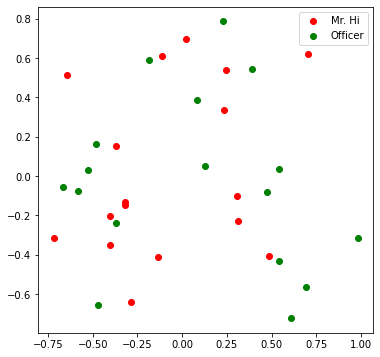

In [ ]:
def visualize_emb(emb):
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(6, 6))
  club1_x = []
  club1_y = []
  club2_x = []
  club2_y = []
  for node in G.nodes(data=True):
    if node[1]['club'] == 'Mr. Hi':
      club1_x.append(components[node[0]][0])
      club1_y.append(components[node[0]][1])
    else:
      club2_x.append(components[node[0]][0])
      club2_y.append(components[node[0]][1])
  plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
  plt.scatter(club2_x, club2_y, color="green", label="Officer")
  plt.legend()
  plt.show()

# Visualize the initial random embeddding
visualize_emb(emb)

### Learned Node Embeddings

In [ ]:
#Function to get accuracy of embedding model
def accuracy(pred,label):
  """
  pred: Tensor containing prediction
  label: Long Tensor with labels

  """
  pred_ =  (pred > 0.5).long()
  accu =  torch.sum(pred_==label)/label.shape[0]

  return accu

In [ ]:
accuracy(torch.rand(10),torch.zeros(10))

tensor(0.4000)

In [ ]:
pred = torch.rand(10)


In [ ]:
# Training Loop


from torch.optim import SGD

def train(emb,loss_fn,sigmoid,train_label,train_edge):
  epochs = 500
  learning_rate = 0.1
  optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)

  for i in range(epochs):
    optimizer.zero_grad()
    embeddings = emb(train_edge)
    node1_embeddings = embeddings[0,:,:]
    node2_embeddings = embeddings[1,:,:]
    dot_prod = torch.sum(node1_embeddings*node2_embeddings,axis = 1)
    sig = sigmoid(dot_prod)
    loss = loss_fn(sig,train_label)
    accu = accuracy(sig,train_label)
    loss.backward()
    optimizer.step()
    if i%10==0:
       print("Loss: {} , Accuracy : {}".format(loss.item(),accu))

loss_fn = nn.BCELoss()
sigmoid = nn.Sigmoid()

#Get positive and negative labels

pos_label = torch.ones(pos_edge_index.shape[1],) #Shape: [78]
neg_label = torch.zeros(neg_edge_index.shape[1],) #Shape : [78]


#Concatenate labels into one tensor
train_label = torch.cat([pos_label, neg_label], dim=0) #Shape: [156]
train_edge = torch.cat([pos_edge_index,neg_edge_index], dim = 1) #Shape: [2,156]

train(emb,loss_fn,sigmoid,train_label,train_edge)


Loss: 0.019652383401989937 , Accuracy : 1.0
Loss: 0.019380172714591026 , Accuracy : 1.0
Loss: 0.0188706386834383 , Accuracy : 1.0
Loss: 0.018300101161003113 , Accuracy : 1.0
Loss: 0.017729591578245163 , Accuracy : 1.0
Loss: 0.017178960144519806 , Accuracy : 1.0
Loss: 0.016653692349791527 , Accuracy : 1.0
Loss: 0.016154391691088676 , Accuracy : 1.0
Loss: 0.015680065378546715 , Accuracy : 1.0
Loss: 0.015229267999529839 , Accuracy : 1.0
Loss: 0.014800498262047768 , Accuracy : 1.0
Loss: 0.014392311684787273 , Accuracy : 1.0
Loss: 0.01400336530059576 , Accuracy : 1.0
Loss: 0.013632413931190968 , Accuracy : 1.0
Loss: 0.013278312049806118 , Accuracy : 1.0
Loss: 0.012940009124577045 , Accuracy : 1.0
Loss: 0.012616537511348724 , Accuracy : 1.0
Loss: 0.012306979857385159 , Accuracy : 1.0
Loss: 0.012010534293949604 , Accuracy : 1.0
Loss: 0.01172641571611166 , Accuracy : 1.0
Loss: 0.01145392656326294 , Accuracy : 1.0
Loss: 0.011192390695214272 , Accuracy : 1.0
Loss: 0.01094120368361473 , Accuracy 

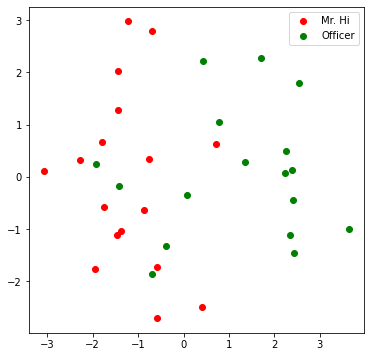

In [ ]:
visualize_emb(emb)

## Deep Walk with PyTorch Geometric

In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

1.12.1+cu113


In [2]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


     |████████████████████████████████| 8.9 MB 1.8 MB/s 
     |████████████████████████████████| 3.5 MB 1.9 MB/s 
     |████████████████████████████████| 2.5 MB 1.9 MB/s 
     |████████████████████████████████| 280 kB 7.4 MB/s 


To demonstrate, we make use of the `Cora` dataset, which is a citation network where nodes represent documents. Each node is described by a 1433-dimensional bag-of-words feature vector. Two documents are connected if there exists a citation link between them. The documents belong to 7 different classes.

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [4]:

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
#The bag of words feature vector is normalized.


print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

Processing...



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


Done!


In [5]:
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [6]:
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [ ]:
#Features corresponding to first node
node0_features = data.x[0]
len(node0_features)

1433

### Baseline Model with only node features

As a baseline, we can use a simple multi class logistic regression model with just node features.

In [ ]:
X_full = data.x.numpy()
y_full = data.y.numpy()

In [ ]:
train_mask = data.train_mask.numpy()
valid_mask = data.val_mask.numpy()
#Use validation data also for training
train_mask2 = train_mask | valid_mask


In [ ]:
X_train = X_full[train_mask2,:]
y_train = y_full[train_mask2]
X_test =  X_full[~train_mask2,:]
y_test =  y_full[~train_mask2]

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=5, random_state=0,max_iter=10000).fit(X_train, y_train)


In [ ]:
from sklearn.metrics import accuracy_score

test_preds = clf.predict(X_test)
accuracy_score(y_test,test_preds)
print(f"Accuracy when using node features only : {accuracy_score(y_test,test_preds) :.3f}")

0.7001934235976789

### Understanding Node2Vec Parameters

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torch_geometric.nn import Node2Vec

model = Node2Vec(data.edge_index, embedding_dim=128, 
                 walk_length=11,                        # length of random walk
                 context_size=10, walks_per_node=2,
                 num_negative_samples=1, 
                 p=1, q=1,                             # bias parameters, p = q for DeepWalk
                 sparse=True).to(device)



`walk_length`: Length of each random walk <br>
`context_size`: Within each walk embeddings are optimized, to maximize similarity with nodes that are within a window of this size. <br>

In the image below, the sentence is equivalent to a random walk of `walk_length = 9` and a `context_size=5`.

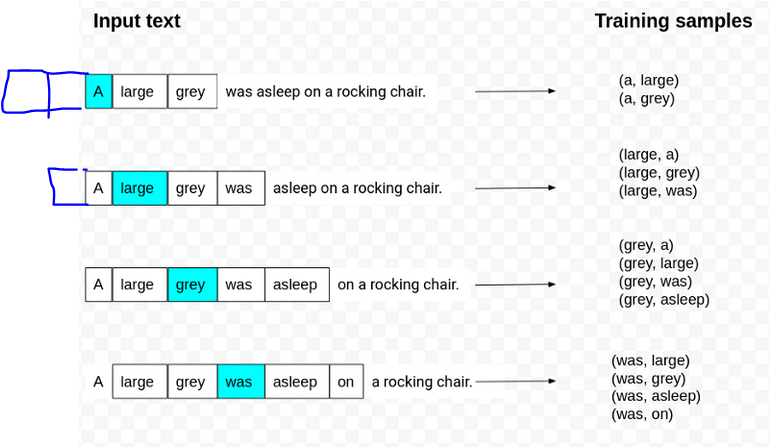


`walks_per_node`: Number of random walks to be sampled for each node in the graph <br>

`p`: return parameter.<br>
  * High value of p: Explores more <br>
  * Low value of p : Returns to previous node and stays local. <br>

`q`: in-out parameter <br>
  * High value of q: Stays local (BFS) <br>
  * Small value of q: Explore more(DFS) <br>


By setting `p` low  and `q` large, the embeddings learn "homophily".
By setting `p` large and `q` low, the embeddings learn "structural similarity."

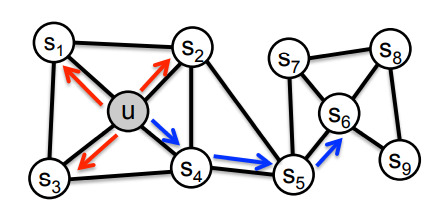

Here `u` and `s1` are homopholous, while `u` and `s6` are structurally similar.

### Understanding How PyTorch Geometric Creates Batches

In [ ]:
loader = model.loader(batch_size=1, shuffle=True,
                          num_workers=2)

Here `batch_size` represent the number of nodes to include in each batch. If `batch_size = 1` , each batch contains random walks for  just one node in the graph. 

In [ ]:
len(loader)

2708

In [ ]:
batch = next(iter(loader))

Each batch contains positive random walks and negative random walks.

In [ ]:
positive_rw,negative_rw = batch[0],batch[1]

The number of columns is equal to the `context_size`.

In [ ]:
positive_rw.shape,negative_rw.shape

(torch.Size([4, 10]), torch.Size([4, 10]))

In [ ]:
positive_rw

tensor([[2561, 2560, 2561, 2560, 1717, 1358, 1040, 1169,  111, 1169],
        [2561, 2560, 1114, 1717, 1731, 1711, 1629,    5, 1629,    5],
        [2560, 2561, 2560, 1717, 1358, 1040, 1169,  111, 1169, 1714],
        [2560, 1114, 1717, 1731, 1711, 1629,    5, 1629,    5, 1629]])

As seen above, two random walks have been sampled for node 1241. Two contexts of size 10 can be accomodated within a random walk of length 11, so there are 2x2=4 records per batch.


### Build and Evaluate the DeepWalk Model

In [ ]:
#Set to more useful parameter values
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                     context_size=10, walks_per_node=10,
                     num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True,
                          num_workers=2)
optimizer = torch.optim.SparseAdam(list(model.parameters()),lr = 0.01)#Implements lazy version of Adam algorithm suitable for sparse tensors.

In [ ]:
def train():
  model.train()
  total_loss = 0
  for pos_rw,neg_rw in loader:
    optimizer.zero_grad() #Clear Gradients
    loss = model.loss(pos_rw.to(device),neg_rw.to(device))
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  return total_loss/len(loader)


Train for multiple epochs

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

for epoch in range(100):
  loss = train()
  if epoch % 10 == 0:
    print(f'Epoch: {epoch} , Loss:{loss:.4f}')

Epoch: 0 , Loss:8.1710
Epoch: 1 , Loss:6.0839
Epoch: 2 , Loss:4.9715
Epoch: 3 , Loss:4.1411
Epoch: 4 , Loss:3.4838
Epoch: 5 , Loss:2.9644
Epoch: 6 , Loss:2.5506
Epoch: 7 , Loss:2.2263
Epoch: 8 , Loss:1.9596
Epoch: 9 , Loss:1.7451
Epoch: 10 , Loss:1.5708
Epoch: 11 , Loss:1.4327
Epoch: 12 , Loss:1.3218
Epoch: 13 , Loss:1.2341
Epoch: 14 , Loss:1.1655
Epoch: 15 , Loss:1.1074
Epoch: 16 , Loss:1.0639
Epoch: 17 , Loss:1.0258
Epoch: 18 , Loss:0.9971
Epoch: 19 , Loss:0.9759
Epoch: 20 , Loss:0.9539
Epoch: 21 , Loss:0.9395
Epoch: 22 , Loss:0.9266
Epoch: 23 , Loss:0.9141
Epoch: 24 , Loss:0.9044
Epoch: 25 , Loss:0.8958
Epoch: 26 , Loss:0.8884
Epoch: 27 , Loss:0.8826
Epoch: 28 , Loss:0.8775
Epoch: 29 , Loss:0.8724
Epoch: 30 , Loss:0.8688
Epoch: 31 , Loss:0.8644
Epoch: 32 , Loss:0.8620
Epoch: 33 , Loss:0.8586
Epoch: 34 , Loss:0.8550
Epoch: 35 , Loss:0.8535
Epoch: 36 , Loss:0.8500
Epoch: 37 , Loss:0.8494
Epoch: 38 , Loss:0.8477
Epoch: 39 , Loss:0.8461
Epoch: 40 , Loss:0.8444
Epoch: 41 , Loss:0.8425
Ep

In [ ]:
model.eval()
z = model().cpu() # Get trained embedding matrix
z.shape

torch.Size([2708, 128])

Function to visualize the embeddings using T-SNE.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


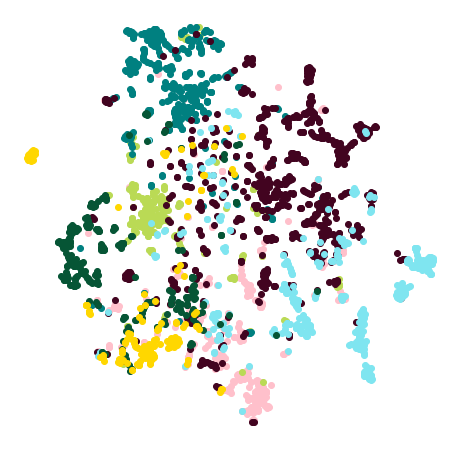

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

@torch.no_grad()
def visualize_emb2(emb):

  y = data.y.cpu().numpy()
  z = emb.numpy()
  z_ = TSNE(n_components=2).fit_transform(z)
  colors = [ '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535','#ffd700']
  plt.figure(figsize=(8,8))
  for i in range(dataset.num_classes):
    plt.scatter(z_[y==i,0],z_[y==i,1],color= colors[i])
  plt.axis("off")
  plt.show()

visualize_emb2(z)

The Node2Vec model also comes with a node2vec model that allows you to evaluate the quality of the embeddings by passing the embeddgins to a downstream multi-class logistic regression model.

In [ ]:
help(model.test)

Help on method test in module torch_geometric.nn.models.node2vec:

test(train_z: torch.Tensor, train_y: torch.Tensor, test_z: torch.Tensor, test_y: torch.Tensor, solver: str = 'lbfgs', multi_class: str = 'auto', *args, **kwargs) -> float method of torch_geometric.nn.models.node2vec.Node2Vec instance
    Evaluates latent space quality via a logistic regression downstream
    task.



In [ ]:
model.eval()
z = model()
acc = model.test(z[data.train_mask], data.y[data.train_mask],
          z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)

print(f"Accuracy when using only node embeddings : {acc :.3f}")

0.732

### Build and Evalaute a Model with Node Features and Node Embeddings

In [ ]:
emb = z.detach().cpu().numpy()

In [ ]:
emb.shape

(2708, 128)

In [ ]:
X_train_emb = emb[train_mask2,:]
X_test_emb = emb[~train_mask2,:]

In [ ]:
X_train.shape,X_test.shape

((640, 1433), (2068, 1433))

In [ ]:
X_train_emb.shape,X_test_emb.shape

((640, 128), (2068, 128))

In [ ]:
X_train2 = np.hstack((X_train,X_train_emb))
X_train2.shape

(640, 1561)

In [ ]:
X_test2 = np.hstack((X_test,X_test_emb))
X_test2.shape

(2068, 1561)

In [ ]:
clf2 = LogisticRegressionCV(cv=5, random_state=0,max_iter=10000).fit(X_train2, y_train)


In [ ]:
test_preds = clf2.predict(X_test2)
print(f"Accuracy when using node features and node embeddings : {accuracy_score(y_test,test_preds) :.3f}")

Accuracy when using node features and node embeddings : 0.796


## Limitations

*  This method is transductive, i.e. it is applicable only to in-sample data. If the graph is expanded by adding a new node, there is no way to use the existing model to get an embedding for the new node.   
* These methods may not capture structural similarity as a random walk may never reach a structurally similar node. This can be resolved using "anonymous walks".

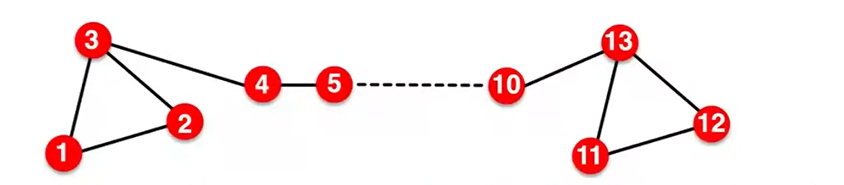
* These techniques cannot utilize node, edge or graph feautures.
* No sharing of parameters between nodes with every node requiring a unique embedding. Becomes problematic for large graphs.



# Graph Neural Networks

## Limitations of Traditional Approaches

One possible approach of doing deep learning is to concatenate the adjacency matrix with the node features as shown below and then pass it through an MLP.

In [ ]:
import networkx as nx
G1 = nx.Graph()
G1.add_nodes_from(['A','B','C','D','E'])
G1.add_edges_from([('A','B'),('A','D'),('A','C'),('B','D'),('C','D'),('B','E'),('D','E')])
# Add node features
attrs = {'A': {"F1": 0.65, "F2": 1.45},'B': {"F1": 0.34, "F2": 0.76},'C': {"F1": 1.23, "F2": 1.34},
         'D': {"F1": 0.86, "F2": 0.43},'E': {"F1": 1.1, "F2": 0.87}}
nx.set_node_attributes(G1, attrs)

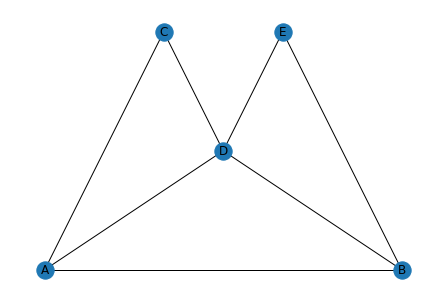

In [ ]:
import matplotlib.pyplot as plt
nx.draw_planar(G1,with_labels = True)

In [ ]:
nx.get_node_attributes(G1,"F1")

{'A': 0.65, 'B': 0.34, 'C': 1.23, 'D': 0.86, 'E': 1.1}

In [ ]:
nx.get_node_attributes(G1,"F2")

{'A': 1.45, 'B': 0.76, 'C': 1.34, 'D': 0.43, 'E': 0.87}

In [ ]:
nx.adjacency_matrix(G1).todense()

matrix([[0, 1, 1, 1, 0],
        [1, 0, 0, 1, 1],
        [1, 0, 0, 1, 0],
        [1, 1, 1, 0, 1],
        [0, 1, 0, 1, 0]])

In [ ]:
import numpy as np
def get_features(G):
  f1 = nx.get_node_attributes(G,"F1").values()
  f2 = nx.get_node_attributes(G,"F2").values()
  #Combine features
  fs = np.vstack((list(f1),list(f2))).T
  #adjacency matrix
  am =nx.adjacency_matrix(G1).todense()
  #combined feature matrix
  fm = np.hstack((am,fs))

  return torch.tensor(fm).float()


In [ ]:
input_G1 = get_features(G1)
input_G1

tensor([[0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.6500, 1.4500],
        [1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.3400, 0.7600],
        [1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.2300, 1.3400],
        [1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.8600, 0.4300],
        [0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.1000, 0.8700]])

In [ ]:
from torch import nn
# Create an MLP Model
class MLP(torch.nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(1)
    self.fc1 =  nn.Linear(7,4)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(4,1)
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    o1 = self.fc1(x)
    o2 = self.relu(o1)
    o3 = self.fc2(o2)
    o4 = self.sigmoid(o3)
    return(o4)



In [ ]:
MLP = MLP()

In [ ]:
G1_preds = MLP(input_G1)
G1_preds

tensor([[0.4656],
        [0.4338],
        [0.4733],
        [0.4400],
        [0.4678]], grad_fn=<SigmoidBackward0>)

Two limitations become obvious.

1) The size of the input layer scales with the size of the graph.<br>
2) Once a model is trained for a graph of one size, it cannot be used for a larger graph.

The third limitation is that this approach is sensitive to node ordering, in other words it is NOT **permutation invariant**.

In [ ]:
G2 = nx.Graph()
G2.add_nodes_from(['A','B','C','D','E'])
G2.add_edges_from([('B','A'),('B','D'),('B','C'),('A','D'),('C','D'),('A','E'),('D','E')])
# Add node features
attrs = {'B': {"F1": 0.65, "F2": 1.45},'A': {"F1": 0.34, "F2": 0.76},'C': {"F1": 1.23, "F2": 1.34},
         'D': {"F1": 0.86, "F2": 0.43},'E': {"F1": 1.1, "F2": 0.87}}
nx.set_node_attributes(G2, attrs)

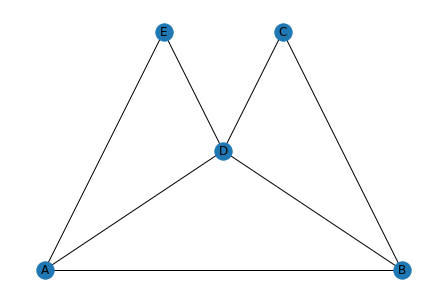

In [ ]:
nx.draw_planar(G2,with_labels = True)

In [ ]:
nx.is_isomorphic(G1,G2)

True

In [ ]:
input_G2 = get_features(G2)
input_G2

tensor([[0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.3400, 0.7600],
        [1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.6500, 1.4500],
        [1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.2300, 1.3400],
        [1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.8600, 0.4300],
        [0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.1000, 0.8700]])

In [ ]:
G2_preds = MLP(input_G2)

In [ ]:
G2_preds

tensor([[0.4682],
        [0.4506],
        [0.4733],
        [0.4400],
        [0.4678]], grad_fn=<SigmoidBackward0>)

In [ ]:
G1_preds

tensor([[0.4656],
        [0.4338],
        [0.4733],
        [0.4400],
        [0.4678]], grad_fn=<SigmoidBackward0>)

The only way to overcome this is to train the network with all possible permutations of the graph which is clearly infeasible, the alternative is to use Graph Convolutions which are **permutation invariant**.

## Deep Encoders

Unlike Node2Vec and DeepWalk, GNNs are deep encoders

$$ ENC(u) = f(z_u) $$

Where $f$ can be multiple layers of non-linear transformations based on graph structure.

## Graph Convolutional Networks

GCN's generate node embeddings by aggregating information from its local neighborhood.

Layer $k$ embeddings gets informations from nodes that are $k$ hops away.

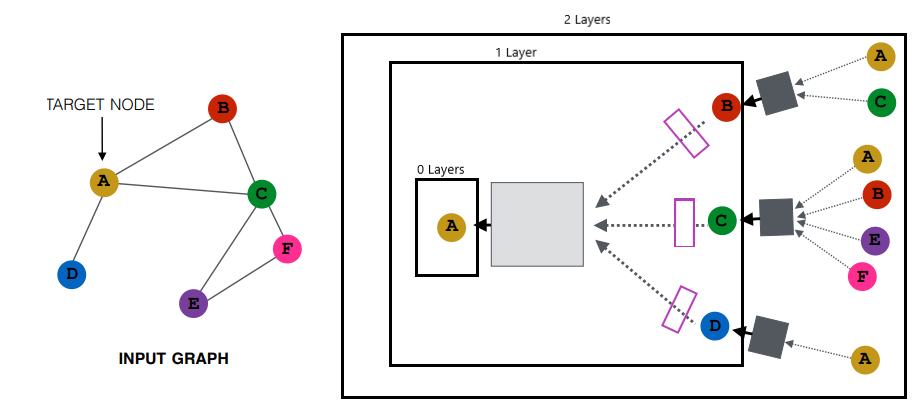

The computation graph for each node is defined by its local neighborhood.

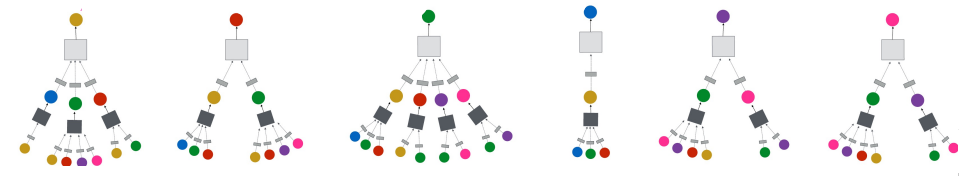

### A Single Layer of a GNN

![](https://firebasestorage.googleapis.com/v0/b/firescript-577a2.appspot.com/o/imgs%2Fapp%2FMy_Knowledge_Network%2F-oTE1rL3Ov.png?alt=media&token=2e76f8f0-eb19-4442-bcad-03e8a97d4a87)

**1) Message** <br>
 Each node $u$ will compute a message to be passed on to the next layer $l$ based on the hiddens state or embedding of the node in the previous layer $l-1$.

$$\textbf{m}_u^{(l)} = MSG^{(l)}\big( \textbf{h}_u^{(l-1)})$$


$MSG$ can be a linear layer in which case.

$$\textbf{m}_u^{(l)} = W^{(l)}\big( \textbf{h}_u^{(l-1)})$$

where $W$ is a weight matrix.


**2) Aggregation** <br>

Each node $v$ will aggrgate messages fron its neighbors.

$$\textbf{h}_v^{(l)} = AGG^{(l)}\big(\{ {\textbf{m}_u^{(l)}, u \in N(v)}\big\})$$

$AGG$ can be $Sum(\cdot), Mean(\cdot),Max(\cdot), LSTM(\cdot)$

Aggregations should be permutation invariant.


### GraphSAGE

There are different flavors of graph convolution depending on how the  transformations are computed. For a full list see 
[here](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers)


Update rule for GraphSAGE(`SAGEConv` in PyG) is defined as follows:
$$\textbf{h}_{N(v)}^k ← \frac{1}{|N(v)|}\sum_{u\in N(v)}  \textbf{h}_u^{(k-1)}$$

$$\textbf{h}_v^{(k)} ← \sigma \bigg(\textbf{W}^k \cdot CONCAT(\textbf{h}_v^{k-1},\textbf{h}_{N(v)}^k) \bigg)$$

$L_2$ normalization is applied to $h_v^{(k)}$ at every layer to make length 1

where <br>
$\textbf{h}_v^{(k)}$ is the vector representation of node $v$ <br>
$\textbf{W}^k$ is a weight matrix for layer $k$ <br>
$\sigma$ is a non-linearity. 


### GraphSAGE in PyG

In [6]:
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F

In [21]:
class GCN1(torch.nn.Module):
  def __init__(self,hidden_channels_1,hidden_channels_2):
    super().__init__()
    torch.manual_seed(1)
    self.conv1 = SAGEConv(dataset.num_features,hidden_channels_1,normalize = True)
    self.conv2 = SAGEConv(hidden_channels_1,hidden_channels_2,normalize = True)
    self.conv3 = SAGEConv(hidden_channels_2,dataset.num_classes,normalize = True)

  def forward(self,x,edge_index):
    out = self.conv1(x,edge_index)
    out = out.relu()
    out = F.dropout(out,p=0.5,training= self.training)
    out = self.conv2(out,edge_index)
    out = out.relu()
    out = F.dropout(out,p=0.5,training= self.training)
    out = self.conv3(out,edge_index)

    return out

model = GCN1(hidden_channels_1 = 128,hidden_channels_2 = 32)
print(model)

GCN1(
  (conv1): SAGEConv(1433, 128, aggr=mean)
  (conv2): SAGEConv(128, 32, aggr=mean)
  (conv3): SAGEConv(32, 7, aggr=mean)
)


In [22]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

optimizer = torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


def train():
  model.train()
  optimizer.zero_grad() #Clear gradients
  out = model(data.x,data.edge_index) #Forward pass
  loss = criterion(out[data.train_mask],data.y[data.train_mask]) #Compute loss just for nodes in training data
  loss.backward() #Derive gradients
  optimizer.step() #Update parameters using Adam
  return loss.item()



def test():
  model.eval()
  out = model(data.x,data.edge_index)
  pred = out.argmax(dim=1) # Use class with highest probability
  test_correct = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = test_correct.sum()/ data.test_mask.sum()
  return test_acc


for epoch in range(1,101):
  loss = train()
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


<IPython.core.display.Javascript object>

Epoch: 001, Loss: 2.0309
Epoch: 002, Loss: 1.9303
Epoch: 003, Loss: 1.8411
Epoch: 004, Loss: 1.6961
Epoch: 005, Loss: 1.5598
Epoch: 006, Loss: 1.4537
Epoch: 007, Loss: 1.4430
Epoch: 008, Loss: 1.3757
Epoch: 009, Loss: 1.3425
Epoch: 010, Loss: 1.3428
Epoch: 011, Loss: 1.2995
Epoch: 012, Loss: 1.2586
Epoch: 013, Loss: 1.2636
Epoch: 014, Loss: 1.2366
Epoch: 015, Loss: 1.2239
Epoch: 016, Loss: 1.2216
Epoch: 017, Loss: 1.2159
Epoch: 018, Loss: 1.1960
Epoch: 019, Loss: 1.2031
Epoch: 020, Loss: 1.1972
Epoch: 021, Loss: 1.1935
Epoch: 022, Loss: 1.1855
Epoch: 023, Loss: 1.1737
Epoch: 024, Loss: 1.1693
Epoch: 025, Loss: 1.1779
Epoch: 026, Loss: 1.1682
Epoch: 027, Loss: 1.1673
Epoch: 028, Loss: 1.1663
Epoch: 029, Loss: 1.1653
Epoch: 030, Loss: 1.1635
Epoch: 031, Loss: 1.1711
Epoch: 032, Loss: 1.1586
Epoch: 033, Loss: 1.1579
Epoch: 034, Loss: 1.1581
Epoch: 035, Loss: 1.1507
Epoch: 036, Loss: 1.1546
Epoch: 037, Loss: 1.1533
Epoch: 038, Loss: 1.1529
Epoch: 039, Loss: 1.1464
Epoch: 040, Loss: 1.1521


In [23]:
acc_graph_sage = test()
print(f"Accuracy when using Graph SAGE: {acc_graph_sage :.3f}")

Accuracy when using Graph SAGE: 0.795


### Graph Attention Networks (GAT)
 In GraphSAGE, the message  received from each neighbor $u$ of node $v$ is given the same weight $\frac{1}{N(v)}$

[GAT](https://arxiv.org/abs/1710.10903) allows to assign a different weight to message from different neighbors.

Let $\alpha_{vu}$ indicate the importance of message from node $u$ to node $v$.

Update rule for GAT(`GATConv` in PyG) is defined as follows:
$$\textbf{h}_{N(v)}^k ← \sum_{u\in N(v) } \alpha_{vu} \textbf{W}^k \textbf{h}_u^{(k-1)}$$

$$\textbf{h}_v^{(k)} ← \sigma \bigg(\textbf{h}_{N(v)}^k \bigg)$$

**Note**: For GAT, $N(v)$ includes $v$.

#### **Computing Attention Weights**

The un-normalized attention or weight given to the edge $vu$ is given 
by 

$$e_{vu} = \textbf{a}(\textbf{W}^{(l)}\textbf{h}_u^{(l-1)},\textbf{W}^{(l)}\textbf{h}_v^{(l-1)})$$


$\textbf{a}$ is a feed forward neural network with a Leaky RELU.

![](https://firebasestorage.googleapis.com/v0/b/firescript-577a2.appspot.com/o/imgs%2Fapp%2FMy_Knowledge_Network%2FMg1LTN5A1X.PNG?alt=media&token=1e454df6-849c-4126-b54a-6337ec1f2386)

The incoming weights are normalized using a Softmax.

$$\alpha_{vu} = \frac{exp(e_{vu})}{\sum_{k \in N(v)} exp(e_{vk})}$$

#### **Multi-Headed Attention**

A multi-headed attention mechanism involves learning multiple attention scores for an edge.


$$\textbf{h}_v^{(k)}[1] ← \sigma \bigg(\textbf{h}_{N(v)}^k\sum_{u\in N(v) } \alpha_{vu}^1 \textbf{W}^k \textbf{h}_u^{(k-1)}\bigg)$$
$$\textbf{h}_v^{(k)}[2] ← \sigma \bigg(\textbf{h}_{N(v)}^k\sum_{u\in N(v) } \alpha_{vu}^2 \textbf{W}^k \textbf{h}_u^{(k-1)}\bigg)$$
$$\textbf{h}_v^{(k)}[3] ← \sigma \bigg(\textbf{h}_{N(v)}^k\sum_{u\in N(v) } \alpha_{vu}^3 \textbf{W}^k \textbf{h}_u^{(k-1)}\bigg)$$

This results in multiple embeddgings for a node which can be aggrgated by concatenation or summation.

### GAT in PyG

In [15]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden_channels = 8
    self.head1 = 8 # No of attention heads in Layer 1
    self.head2 = 1 # No of attention heads in Layer 2
    torch.manual_seed(1)
    self.conv1 = GATConv(in_channels = dataset.num_features,out_channels = self.hidden_channels,
                         heads = self.head1, dropout = 0.5) 
    #Note: above layer generates 8 embeddings per node  due to multi headed attention and concatenates them
    self.conv2 = GATConv(in_channels = self.hidden_channels*self.head1, out_channels = dataset.num_classes,concat=False,
                         heads = self.head2, dropout = 0.5)
    

  def forward(self, x, edge_index):
    out = F.dropout(x,p=0.6,training =self.training)
    out = self.conv1(out,edge_index)
    out = F.elu(out)#https://pytorch.org/docs/stable/generated/torch.nn.ELU.html
    out = F.dropout(out,p=0.6,training=self.training)
    out = self.conv2(out,edge_index)

    return out


  

In [16]:
model = GAT()
print(model)

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)


In [17]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

optimizer = torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1,101):
  loss = train()
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9477
Epoch: 002, Loss: 1.9346
Epoch: 003, Loss: 1.9198
Epoch: 004, Loss: 1.9051
Epoch: 005, Loss: 1.8836
Epoch: 006, Loss: 1.8659
Epoch: 007, Loss: 1.8669
Epoch: 008, Loss: 1.8442
Epoch: 009, Loss: 1.8209
Epoch: 010, Loss: 1.7978
Epoch: 011, Loss: 1.7735
Epoch: 012, Loss: 1.7331
Epoch: 013, Loss: 1.7516
Epoch: 014, Loss: 1.7088
Epoch: 015, Loss: 1.6716
Epoch: 016, Loss: 1.6834
Epoch: 017, Loss: 1.6055
Epoch: 018, Loss: 1.5911
Epoch: 019, Loss: 1.5768
Epoch: 020, Loss: 1.5473
Epoch: 021, Loss: 1.5018
Epoch: 022, Loss: 1.4718
Epoch: 023, Loss: 1.4289
Epoch: 024, Loss: 1.4547
Epoch: 025, Loss: 1.3966
Epoch: 026, Loss: 1.3622
Epoch: 027, Loss: 1.3471
Epoch: 028, Loss: 1.3339
Epoch: 029, Loss: 1.2983
Epoch: 030, Loss: 1.2526
Epoch: 031, Loss: 1.2017
Epoch: 032, Loss: 1.1817
Epoch: 033, Loss: 1.1200
Epoch: 034, Loss: 1.1083
Epoch: 035, Loss: 1.1137
Epoch: 036, Loss: 1.0515
Epoch: 037, Loss: 1.1060
Epoch: 038, Loss: 1.0562
Epoch: 039, Loss: 1.0320
Epoch: 040, Loss: 1.0868


In [20]:
acc_gat = test()
print(f"Accuracy when using GAT: {acc_gat :.3f}")

Accuracy when using GAT: 0.809
